# Evaluation of Leaving Out Results

In [18]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"], "size": 18})
rc("text", usetex=True)

In [ ]:
slurm_output_path = "../../../LABS/LOO/results/rmse_tables"
files = glob.glob(slurm_output_path + "/*")
extrapolation_predictions = glob.glob(slurm_output_path + "/extrapolation*")

pred_dfs = []
for file in extrapolation_predictions:
    df = pd.read_csv(file)
    pred_dfs.append(df)

all_extrapolation_predictions = pd.concat(pred_dfs)

def get_metrics(n_loo: int, df = all_extrapolation_predictions):
    metrics = {
        "emax": [],
        "rmse_eb": [],
        "rmse_rch": [],
        "mape_eb": [],
        "mape_rch": [],
    }
    _df = df[df["N"] == n_loo]
    emaxs = _df["emax"].unique()
    for emax in emaxs:
        emax_df = _df[_df["emax"] == emax]
        metrics["emax"].append(emax)
        preds_eb = emax_df["eb_pred"].values
        preds_rch = emax_df["r_pred"].values
        true_eb = emax_df["Energy bra"].values
        true_rch = emax_df["Rch"].values
        metrics["rmse_eb"].append(np.sqrt(np.mean((preds_eb - true_eb) ** 2)))
        metrics["rmse_rch"].append(np.sqrt(np.mean((preds_rch - true_rch) ** 2)))
        metrics["mape_eb"].append(np.mean(np.abs((preds_eb - true_eb) / true_eb)) * 100)
        metrics["mape_rch"].append(np.mean(np.abs((preds_rch - true_rch) / true_rch)) * 100)
    return pd.DataFrame(metrics)

all_ns = all_extrapolation_predictions["N"].unique()
all_metrics_df = []
for n in sorted(all_ns):
    metrics = get_metrics(n)
    metrics["N"] = [n] * len(metrics)
    all_metrics_df.append(metrics)
all_metrics_df = pd.concat(all_metrics_df)



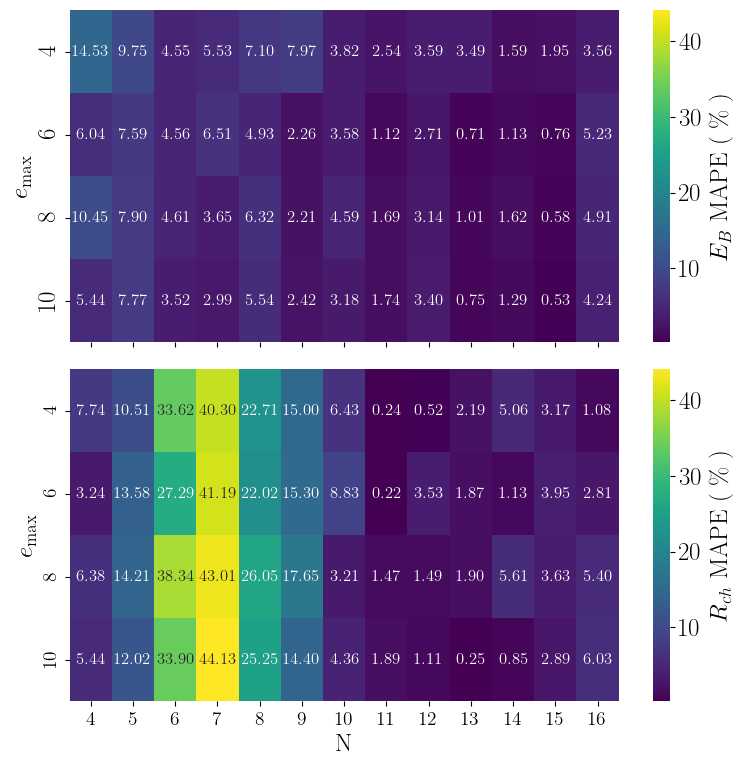

In [26]:
pivot_df = all_metrics_df.pivot(index='emax', columns='N', values='mape_eb')
pivot_df_radii = all_metrics_df.pivot(index='emax', columns='N', values='mape_rch')

vmin = min(pivot_df.min().min(), pivot_df_radii.min().min())
vmax = max(pivot_df.max().max(), pivot_df_radii.max().max())

fig, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

im1 = sns.heatmap(
    pivot_df,
    ax=axs[0],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    annot_kws={"size": 12, "weight": "bold"},
    cbar_kws={'label': r'$E_B$ MAPE' + " ( \% )"}
)
axs[0].set_ylabel("$e_{\max}$", fontsize=18, fontweight="bold")
axs[0].set_xlabel("")
axs[0].tick_params(labelsize=18)
for label in axs[0].get_xticklabels() + axs[0].get_yticklabels():
    label.set_fontweight("bold")

im2 = sns.heatmap(
    pivot_df_radii,
    ax=axs[1],
    annot=True,
    fmt=".2f",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    cbar=True,
    annot_kws={"size": 12, "weight": "bold"},
    cbar_kws={'label': '$R_{ch}$ MAPE' + " ( \% )"}
)
axs[1].set_ylabel("$e_{\max}$", fontsize=18, fontweight="bold")
axs[1].set_xlabel("N", fontsize=18, fontweight="bold")
axs[1].tick_params(labelsize=14)
for label in axs[1].get_xticklabels() + axs[1].get_yticklabels():
    label.set_fontweight("bold")

plt.subplots_adjust(hspace=1.)
plt.tight_layout()
plt.savefig("/Users/jose/Documents/Works/MIT/WIP/BANNANE/final_plots/loo_mape_heatmap.pdf", dpi=300)

In [ ]:
def plot_predictions(N_val, emax_val, df = all_extrapolation_predictions):
    filtered = df[(df["N"] == N_val) & (df["emax"] == emax_val)]

    if filtered.empty:
        print("No data found for N =", N_val, "and emax =", emax_val)
        return

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].scatter(filtered["Energy bra"], filtered["eb_pred"], color="blue", alpha=0.7)
    axs[0].plot(filtered["Energy bra"], filtered["Energy bra"], color="red", linestyle="--")
    axs[0].set_title("EB: Prediction vs True Registered Value")
    axs[0].set_xlabel("Energy bra (True)")
    axs[0].set_ylabel("eb_pred (Prediction)")

    axs[1].scatter(filtered["Rch"], filtered["r_pred"], color="green", alpha=0.7)
    axs[1].plot(filtered["Rch"], filtered["Rch"], color="red", linestyle="--")
    axs[1].set_title("RCH: Prediction vs True Registered Value")
    axs[1].set_xlabel("Rch (True)")
    axs[1].set_ylabel("r_pred (Prediction)")

    plt.tight_layout()
    plt.show()

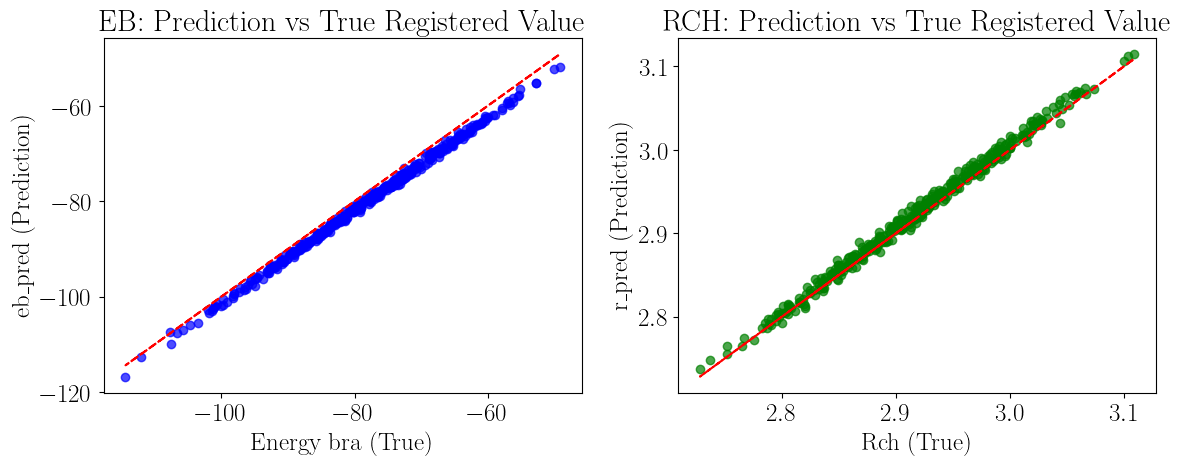

In [22]:
plot_predictions(11, 4)

In [ ]:
def plot_predictions_multifidelity(N_val, df = all_extrapolation_predictions):

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    colors = sns.color_palette("viridis", len(all_extrapolation_predictions["emax"].unique()))

    for ii, emax_val in enumerate(all_extrapolation_predictions["emax"].unique()):
        filtered = df[(df["N"] == N_val) & (df["emax"] == emax_val)]

        axs[0].scatter(filtered["Energy bra"], filtered["eb_pred"], color=colors[ii], alpha=0.7, label=f"e_max = {emax_val}")
        axs[0].plot(filtered["Energy bra"], filtered["Energy bra"], color="black", linestyle="--")

        axs[1].scatter(filtered["Rch"], filtered["r_pred"], color=colors[ii], alpha=0.7)
        axs[1].plot(filtered["Rch"], filtered["Rch"], color="black", linestyle="--")


    axs[0].set_xlabel("Energy bra (True)")
    axs[0].set_ylabel("eb_pred (Prediction)")
    axs[1].set_xlabel("Rch (True)")
    axs[1].set_ylabel("r_pred (Prediction)")
    plt.tight_layout()
    axs[0].legend()
    plt.show()

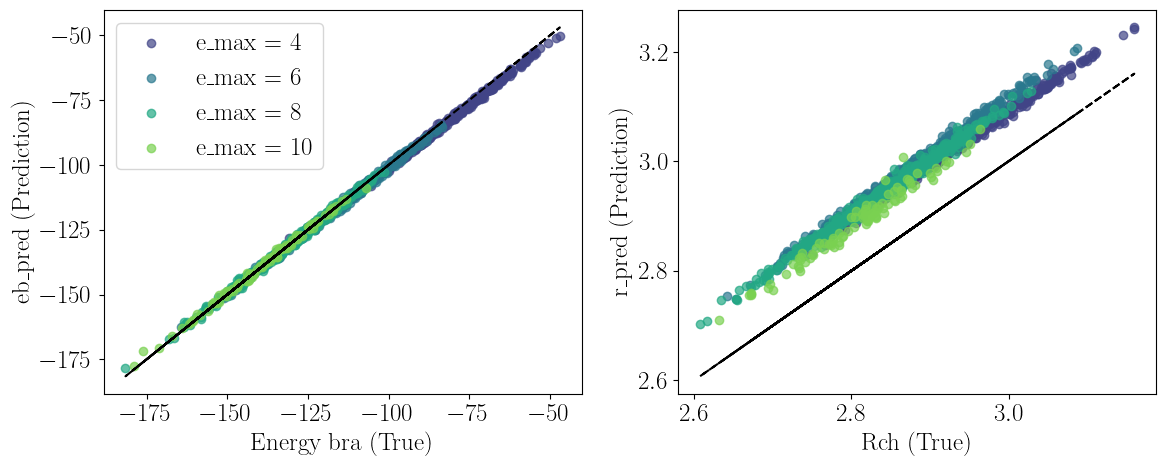

In [48]:
plot_predictions_multifidelity(15)

# Two isotopes Zero shot


In [ ]:
path = "../../../LABS/LEAVEOUT/results/rmse_tables/extrapolation_leaveout_6_10.csv"
zs_df = pd.read_csv(path)
zs_df.head()

,Sample,emax,Ct1S0pp,Ct1S0np,Ct1S0nn,Ct3S1,C1S0,C3P0,C1P1,C3P1,...,Zero,One,Two,Rch,Z,N,eb_pred,r_pred,eb_unc,r_unc
0,10225,4,-0.343045,-0.341340,-0.341117,-0.255424,2.501813,1.092682,-0.114318,-1.246609,...,-4.564599,7.939423,-1.193104,1.702904,8,6,-55.869050,1.193240,0.642651,0.006251
1,102321,4,-0.331308,-0.338095,-0.334400,-0.258081,2.439528,1.344685,0.036590,-1.181207,...,-4.452776,7.639840,-1.153592,1.658805,8,6,-61.465816,1.130093,0.613430,0.006506
2,102650,4,-0.355240,-0.347369,-0.352473,-0.239467,2.700402,1.248044,-0.041280,-1.214342,...,-4.589062,8.127482,-1.361242,1.701570,8,6,-54.624653,1.156002,0.660245,0.006664
3,103036,4,-0.348370,-0.345047,-0.351050,-0.240022,2.634088,0.615263,-0.023407,-0.940425,...,-4.747823,8.553130,-1.479635,1.744658,8,6,-47.754917,1.206012,0.668931,0.006465
4,103297,4,-0.339128,-0.338538,-0.343219,-0.239260,2.584256,0.880345,-0.022479,-1.104563,...,-4.517553,7.829475,-1.236229,1.671483,8,6,-55.682438,1.142294,0.603640,0.006496


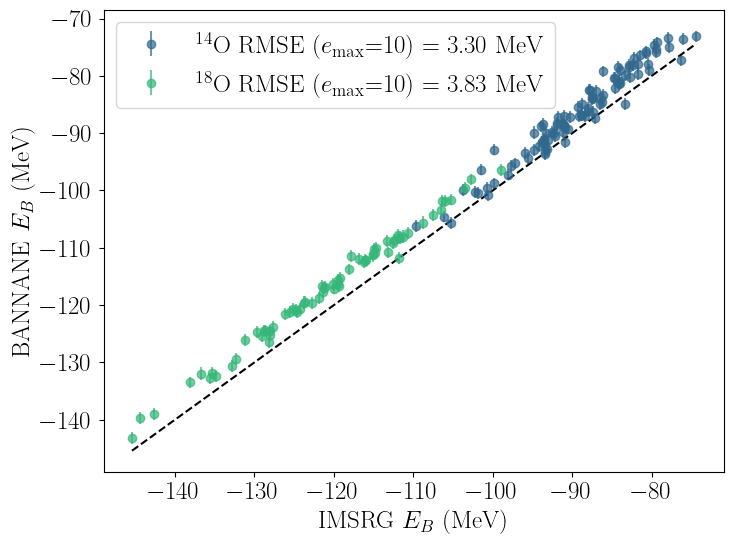

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
emax = 10

colors = sns.color_palette("viridis", n_colors=2)

for n, color in zip([6, 10], colors):
    nzs_df = zs_df[(zs_df["N"] == n) & (zs_df["emax"] == emax)]
    metrics = get_metrics(n, nzs_df)
    plt.errorbar(
        nzs_df["Energy bra"],
        nzs_df["eb_pred"],
        yerr=nzs_df["eb_unc"],
        fmt="o",
        color=color,
        alpha=0.7,
        label=f"$^{{{n+8}}}$O" + r" RMSE ($e_{\max}$=10) = " + f"{metrics['rmse_eb'].values[0]:.2f} MeV"
    )

# Add a 1:1 reference line
min_energy = zs_df.query(f"emax == {emax}")["Energy bra"].min()
max_energy = zs_df.query(f"emax == {emax}")["Energy bra"].max()
ax.plot([min_energy, max_energy], [min_energy, max_energy], color="black", linestyle="--")

ax.set_xlabel("IMSRG $E_{B}$ (MeV)", fontsize=18)
ax.set_ylabel("BANNANE $E_{B}$ (MeV)", fontsize=18)
ax.tick_params(labelsize=18)
plt.legend(fontsize=18)

plt.savefig("extrapolation_6_10.pdf", bbox_inches="tight")
